In [1]:
import torch
import torchvision
import requests
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from torchvision import transforms as tfms
from diffusers import StableDiffusionPipeline, DDIMScheduler

def load_image(url, size=None):
    reponse = requests.get(url, timeout=0.2)
    img = Image.open(BytesIO(reponse.content)).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
# 配置DDIM调度器
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)



safety_checker\model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

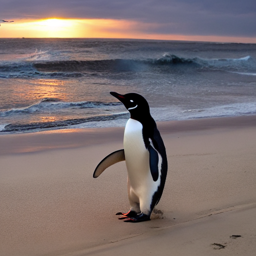

In [4]:
prompt = 'Beautiful DSLR Photograph of a penguin on the beach, golden hour'
negative_prompt = 'blurry, ugly, stock photo'
im = pipe(prompt, negative_prompt=negative_prompt).images[0]
im.resize((256, 256))

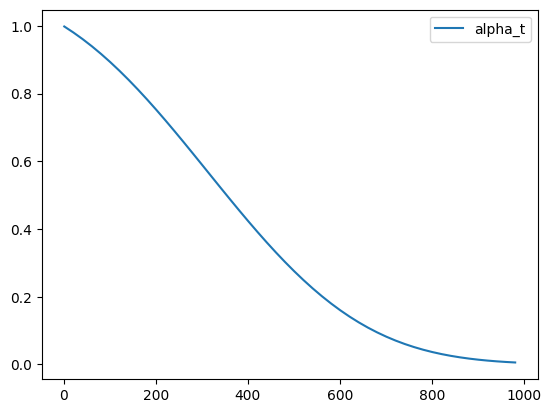

In [5]:
timesteps = pipe.scheduler.timesteps.cpu()
alphas = pipe.scheduler.alphas_cumprod[timesteps]
plt.plot(timesteps, alphas, label='alpha_t')
plt.legend()

In [6]:
pipe.scheduler.set_timesteps(50)
t = pipe.scheduler.timesteps[1]
t.item()

961

In [ ]:
# 采样函数（标准的DDIM采样）
@torch.no_grad()
def sample(prompt, start_step=0, start_latents=None,
           guidance_scale=3.5, num_inference_steps=30,
           num_images_per_prompt=1, do_classifier_free_guidance=True,
           negative_prompt='', device=device):
    # 对文本提示语进行编码
    text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt,
        do_classifier_free_guidance, negative_prompt
    )
    # 配置推理的步数
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # 如果没有起点，就创建一个随机的起点
    if start_latents is None:
        start_latents = torch.randn(1, 4, 64, 64, device=device)
        start_latents *= pipe.scheduler.init_noise_sigma
     
    latents = start_latents.clone()

    for i in tqdm(range(start_step, num_inference_steps)):

        t = pipe.scheduler.timesteps[i]
        # 如果正在进行CFG，则对隐层进行扩展 (负提示词引导)
        latent_model_input = torch.cat([latents]*2) if do_classifier_free_guidance else latents
        
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
        # 预测残留的噪声
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # 进行引导
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        
            # 使用调度器更新步骤
            # latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
            # 现在手动实现
            prev_t = max(1, t.item() - (1000//num_inference_steps)) # t-1
            alpha_t = pipe.scheduler.alphas_cumprod[t.item()]
            alpha_t_prev = pipe.scheduler.alphas_cumprod[prev_t]
            predicted_x0 = (latents - (1-alpha_t).sqrt()*noise_pred) / alpha_t.sqrt()
            direction_pointing_to_xt = (1-alpha_t).sqrt() * noise_pred
            latents = alpha_t_prev.sqrt() * predicted_x0 + direction_pointing_to_xt

    images = pipe.decode_latents(latents)
    images = pipe.numpy_to_pil(images)
    return images

# 生成一张图片，测试一下采样函数
sample('Watercolor painting of a beach sunset', negative_prompt=negative_prompt, num_inference_steps=50)[0].resize((256, 256))



In [9]:
input_image = Image.open('./pexels-photo-8306128.jpeg').convert('RGB')
input_image_prompt = "Photograph of a puppy on the grass"

In [ ]:
# input_image = load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
# input_image = Image.open('./pexels-photo-8306128.jpeg').convert('RGB')
# input_image_prompt = "Photograph of a puppy on the grass"

with torch.no_grad():
    latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1)
l = 0.18215 * latent.latent_dist.sample()


In [ ]:
# 反转 （加噪）
@torch.no_grad()
def invert(start_latents, prompt, guidance_scale=3.5,
           num_inference_steps=80, num_images_per_prompt=1,
           do_classifier_free_guidance=True, negative_prompt='',
           device=device):
    # 对文本提示语进行编码
    text_embeddings = pipe._encode_prompt(
        prompt, device, num_images_per_prompt,
        do_classifier_free_guidance, negative_prompt
    )
    # 已经指定好起点
    latents = start_latents.clone()
    # 用一个列表保存反转的隐层
    intermediate_latents = []
    # 配置推理的步数
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    # 反转的时间步
    timesteps = reversed(pipe.scheduler.timesteps)

    for i in tqdm(range(1, num_inference_steps), 
                  total=num_inference_steps-1, desc='Inverting'):
        # 跳过最后一次迭代
        if i >= num_inference_steps-1:
            continue
        
        t = timesteps[i]
        # 如果正在进行CFG，则对隐层进行扩展 (负提示词引导)

        latent_model_input = torch.cat([latents]*2) if do_classifier_free_guidance else latents
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
        # 预测残留的噪声
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample
        # 进行引导
        if do_classifier_free_guidance:
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        current_t = max(0, t.item() - (1000//num_inference_steps)) # t
        next_t = t # t+1
        alpha_t = pipe.scheduler.alphas_cumprod[current_t]
        alpha_t_next = pipe.scheduler.alphas_cumprod[next_t]
        # 反转的更新步（重新排列更新步，利用xt-1(当前隐层)得到xt（新的隐层））
        latents = (latents - (1-alpha_t).sqrt()*noise_pred) * (alpha_t_next.sqrt() / alpha_t.sqrt()) + (1-alpha_t_next).sqrt()*noise_pred
        
        # 保存
        intermediate_latents.append(latents)

        return torch.cat(intermediate_latents)

inverted_latents = invert(l, input_image_prompt, num_inference_steps=50)
images = pipe.decode_latents(inverted_latents)
images = pipe.numpy_to_pil(images)
images


In [ ]:
with torch.no_grad():
    im = pipe.decode_latents(inverted_latents[-1].unsqueeze(0))
pipe.numpy_to_pil(im)[0]

In [ ]:
pipe(input_image_prompt, 
     latents=inverted_latents[-1][None], 
     num_inference_steps=50, 
     guidance_scale=3.5).images[0]

In [ ]:
# 设置一个起点来"作弊"
start_step = 20
sample(input_image_prompt, 
       start_latents=inverted_latents[-(start_step+1)][None], 
       start_step=start_step, 
       num_inference_steps=50)[0]



In [ ]:
start_step = 10
new_prompt = input_image_prompt.replace('puppy', 'cat')
sample(new_prompt, 
       start_latents=inverted_latents[-(start_step+1)][None], 
       start_step=start_step, 
       num_inference_steps=50)[0]

In [ ]:
# 为什么不直接对输入图像添加噪声，然后用新的文本提示语直接"去噪"呢？
start_step = 10
num_inference_steps = 50
pipe.scheduler.set_timesteps(num_inference_steps, device=device)
noisy_l = pipe.scheduler.add_noise(l, torch.randn_like(l), pipe.scheduler.timesteps[start_step])
sample(new_prompt, start_latents=noisy_l, start_step=start_step, num_inference_steps=num_inference_steps)[0]

In [ ]:
def edit(input_image, input_image_prompt, edit_prompt, num_steps=100,
         start_step=30, guidance_scale=3.5):
    with torch.no_grad():
        latent = pipe.vae.encode(tfms.functional.to_tensor(input_image).unsqueeze(0).to(device)*2-1)
    l = 0.18215 * latent.latent_dist.sample()
    inverted_latents = invert(l, input_image_prompt, num_inference_steps=num_steps)
    final_im = sample(edit_prompt, 
                      start_latents=inverted_latents[-(start_step+1)][None], 
                      start_step=start_step, 
                      num_inference_steps=num_steps, 
                      guidance_scale=guidance_scale)[0]
    return final_im
# And in action:
edit(input_image, 
     'A puppy on the grass', 
     'an old grey dog on the grass',
       num_steps=50, 
       start_step=10)


In [ ]:
edit(input_image, 
     'A puppy on the grass', 
     'a blue dog on the lawn',
       num_steps=50, 
       start_step=12,
       guidance_scale=6)


In [ ]:
edit(input_image,
     'A puppy on the grass',
     'A puppy on the grass',
       num_steps=350,
       start_step=1,
       guidance_scale=7.5)

In [ ]:
edit(input_image,
     'A photograph of a puppy',
     'A photograph of a grey cat',
     num_steps=150,
     start_step=30,
     guidance_scale=5.5)


In [ ]:
# 更换图像
face = load_image('https://images.pexels.com/photos/1493111/pexels-photo-1493111.jpeg', size=(512, 512))
edit(face,
     'A photograph of a face',
     'A photograph of a face with sunglasses',
     num_steps=250,
     start_step=30,
     guidance_scale=3.5)


In [ ]:
edit(face,
     'A photograph of a face',
     'Acrylic palette knife painting of a face, colorful',
     num_steps=250,
     start_step=65,
     guidance_scale=5.5)


In [ ]:
# ControlNet
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(
    'https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png'
)
image

In [ ]:
import  cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
hight_threshold = 200

image = cv2.Canny(image, low_threshold, hight_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnet,  torch_dtype=torch.float16)


In [ ]:
from diffusers import UniPCMultistepScheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(w * (i % cols), h * (i // cols)))
    
    return grid

prompt = ", best  quality, extremely detailed"
prompt - [t + prompt for t in ["Sandra Oh","Kim Kardashian", "rihanna", "taylor swift"]]
generator = [torch.Generator(device=="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt==["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output, images, 2, 2)


In [ ]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://hf.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url) for url in urls
]

image_grid(imgs, 2, 2)

In [ ]:
from controlnet_aux import OpenposeDetector
model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
poses  = [model(img) for img in imgs]
image_grid(poses, 2, 2)


In [ ]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose",
    torch_dtype=torch.float16,
)
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offloading()
pipe.enable_model_xformers_memory_efficient_attention()
generator = [
    torch.Generator(device="cpu").manual_seed(2) for i in range(len(imgs))
]
prompt = "super-hero chraracter, best quality, extremely detailed"
output = pipe(
    [prompt] * len(imgs),
    poses
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(imgs),
    generator=generator,
    num_inference_steps=20,
)
image_grid(output, 2, 2)